In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
import pickle as pkl
from matplotlib import pyplot as plt

import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the

# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights, Qmake_discriminator, VAE_GAN_Model
from data_and_eval_utils import load_preprocessed_snl

# in gan1. We train the VAE_GAN model

2025-07-25 14:31:08.667014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 14:31:09.918411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
data = load_preprocessed_snl()
X_train = data['X_train']

Data loaded from preprocessed_SNL_data.h5


In [ ]:
ATTEMPT_NUM = 12
# To be copied from gan_training_history.txt ---
NUM_TRAIN      = 10 # Number of iterations to train for.
# VAE Architecture
INPUT_SZ       = 57
H1_SZ          = 32 # Hidden layer 1 size
H2_SZ          = 16 # "          " 2 "  "
LATENT_SZ      = 3
# Discriminator Architecture # 8, 2 is on ATLAS-VAE-GAN
DISC_H1_SZ     = 8 # Size of first hidden layer of discriminator  
DISC_H2_SZ     = 2 # "" second hidden layer ""
# Training schedule and parameters
NUM_EPOCHS     = 100
STEPS_EPOCH    = 20 # Steps per epoch
BATCH_SIZE     = 1024
STOP_PATIENCE  = 40
LR_PATIENCE    = 20
LR             = 0.001 # Learning rate
REDUCE_LR_FACTOR = 0.5
VAL_SPLIT      = 0.2 # Validation split
CYCLE_LEN      = 20
SHUFFLE_BOOL   = True
# Hyperparameters
MIN_BETA       = 0
MAX_BETA       = 1
MIN_GAMMA      = 1
MAX_GAMMA      = 1.05
# ---


### Simple training loop. No parameter sweeping

In [ ]:
train = True
save = True
SAVE_PATH = home_path+f"/GAN_trainings/attempt{ATTEMPT_NUM}/" 
early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=LR, patience=LR_PATIENCE, verbose=1)

for i in range(NUM_TRAIN):
    if train:
        tf.keras.backend.clear_session()

        print(f"TRAINING ITERATION {i} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        disc = Qmake_discriminator(INPUT_SZ, DISC_H1_SZ, DISC_H2_SZ) # Modified this to the ATLAS-VAE-GAN

        steps_per_epoch = X_train.shape[0] // BATCH_SIZE
        
        # Modified these setting to match atlas VAE gan repo
        vae = VAE_GAN_Model(
                            enc
                            ,dec
                            ,disc
                            ,cycle_length=CYCLE_LEN
                            ,min_beta=MIN_BETA
                            ,max_beta=MAX_BETA
                            ,min_gamma=MIN_GAMMA
                            ,max_gamma=MAX_GAMMA
                            ,max_epochs=NUM_EPOCHS
                            ,steps_per_epoch=STEPS_EPOCH
                            )
        opt = keras.optimizers.Adam(learning_rate=LR)
        # --
        vae.compile(optimizer=opt)
        history = vae.fit(x=X_train, validation_split=VAL_SPLIT, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=SHUFFLE_BOOL)

        
        # Iterative training. 
        save_path = SAVE_PATH+f"n_{i}/" 
        if save:
            print(f"SAVING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            vae.save_weights(filepath=save_path, save_format='tf')

            # Now save the histories
            with open(save_path + f"training_history.pkl", 'wb') as f:
                pkl.dump(history.history, f)

TRAINING ITERATION 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



2025-07-25 14:31:14.975792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0


Epoch 1/100


2025-07-25 14:31:17.086751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-25 14:31:17.153703: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x559b8931f010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-25 14:31:17.153722: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-25 14:31:17.158642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-25 14:31:17.198117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2025-07-25 14:31:17.340434: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2500/2500 [==============================] - 15s 5ms/step - loss: 21.4606 - reco_loss: 5.4760 - kl_loss: 0.7862 - disc_loss: 0.6378 - d_loss: 0.0000e+00 - raw_loss: 6.2752 - w_kl_loss: 0.5913 - w_disc_loss: 38.9073 - beta: 0.9900 - gamma: 62.2500 - val_loss: 71.7288 - val_reco_loss: 4.9601 - val_kl_loss: 0.5814 - val_d_loss: 2.0940 - val_raw_loss: 5.5415 - val_disc_loss: 0.5362 - val_w_kl_loss: 0.5756 - val_w_disc_loss: 66.1931 - val_gamma: 123.4510 - val_beta: 0.9900 - lr: 1.0000e-06
Epoch 2/100
2500/2500 [==============================] - 10s 4ms/step - loss: 81.5652 - reco_loss: 5.5933 - kl_loss: 0.7609 - disc_loss: 0.5203 - d_loss: 0.0000e+00 - raw_loss: 6.3792 - w_kl_loss: 0.5954 - w_disc_loss: 95.7186 - beta: 1.0000 - gamma: 184.7500 - val_loss: 118.2694 - val_reco_loss: 5.2498 - val_kl_loss: 0.5776 - val_d_loss: 2.2338 - val_raw_loss: 5.8275 - val_disc_loss: 0.4572 - val_w_kl_loss: 0.5776 - val_w_disc_loss: 112.4420 - val_gamma: 245.9510 - val_beta: 1.0000 - lr: 1.0000e-06
Epoch

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2500/2500 [==============================] - 10s 4ms/step - loss: 31.0758 - reco_loss: 4.5545 - kl_loss: 0.9683 - disc_loss: 0.0736 - d_loss: 0.0000e+00 - raw_loss: 5.4881 - w_kl_loss: 0.7069 - w_disc_loss: 31.5456 - beta: 1.0000 - gamma: 429.7500 - val_loss: 35.2655 - val_reco_loss: 5.0115 - val_kl_loss: 1.0177 - val_d_loss: 5.1868 - val_raw_loss: 6.0292 - val_disc_loss: 0.0596 - val_w_kl_loss: 1.0177 - val_w_disc_loss: 29.2363 - val_gamma: 490.9510 - val_beta: 1.0000 - lr: 1.0000e-06
Epoch 5/100
2500/2500 [==============================] - 11s 4ms/step - loss: 31.4993 - reco_loss: 4.7292 - kl_loss: 1.0119 - disc_loss: 0.0567 - d_loss: 0.0000e+00 - raw_loss: 5.7012 - w_kl_loss: 0.7188 - w_disc_loss: 31.2190 - beta: 0.9900 - gamma: 552.2500 - val_loss: 37.5552 - val_reco_loss: 5.0099 - val_kl_loss: 1.0835 - val_d_loss: 5.6148 - val_raw_loss: 6.0934 - val_disc_loss: 0.0513 - val_w_kl_loss: 1.0726 - val_w_disc_loss: 31.4727 - val_gamma: 613.4510 - val_beta: 0.9900 - lr: 1.0000e-06
Epoch 

Plot Loss vs epoch history.

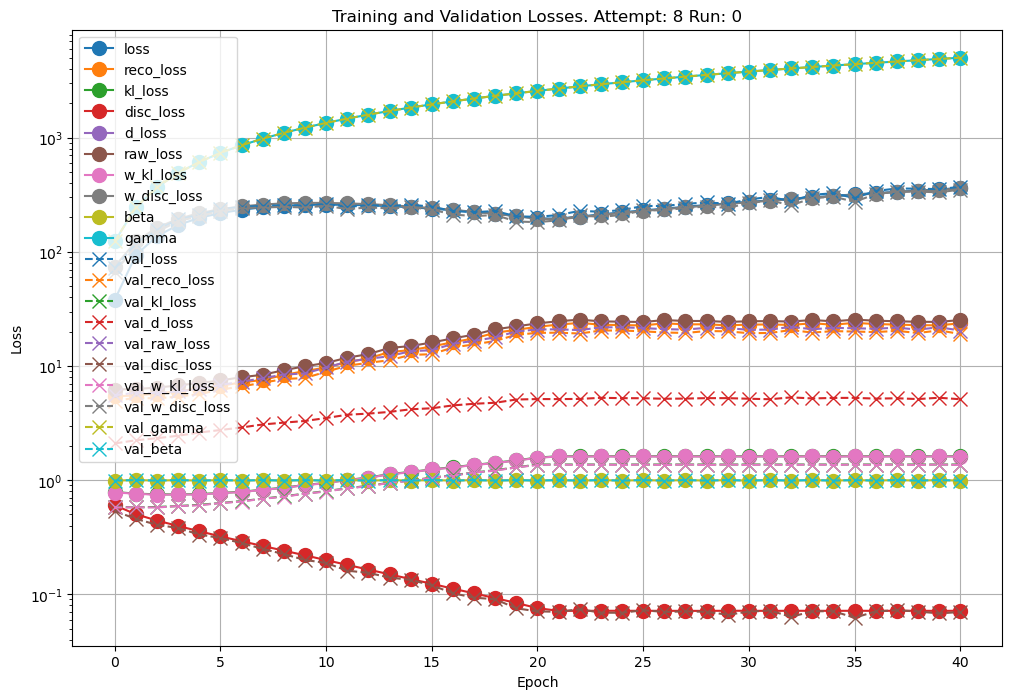

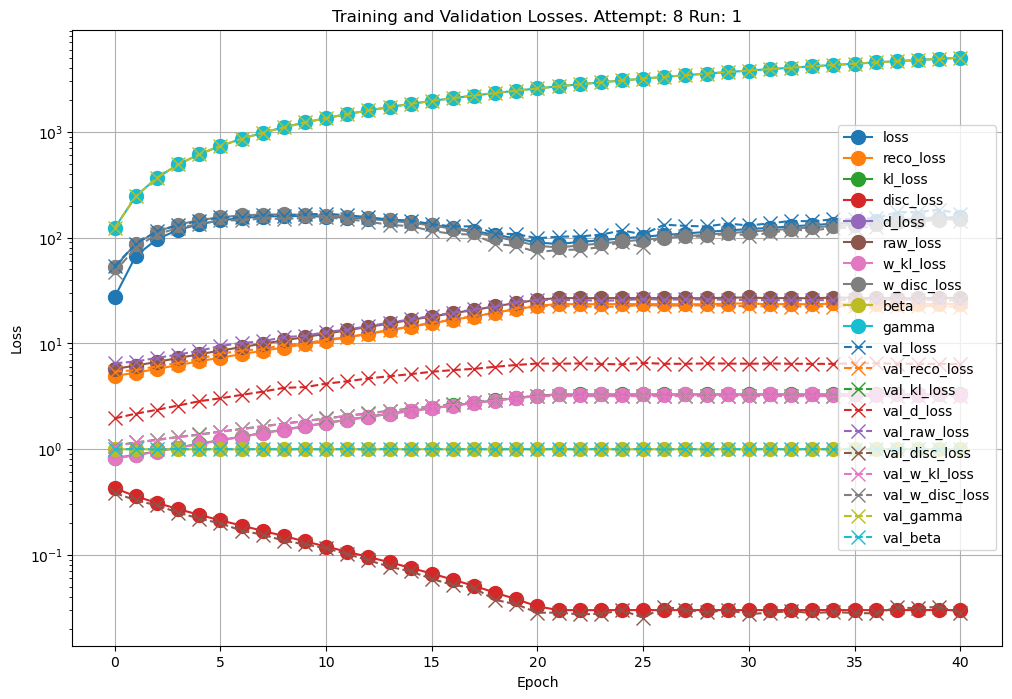

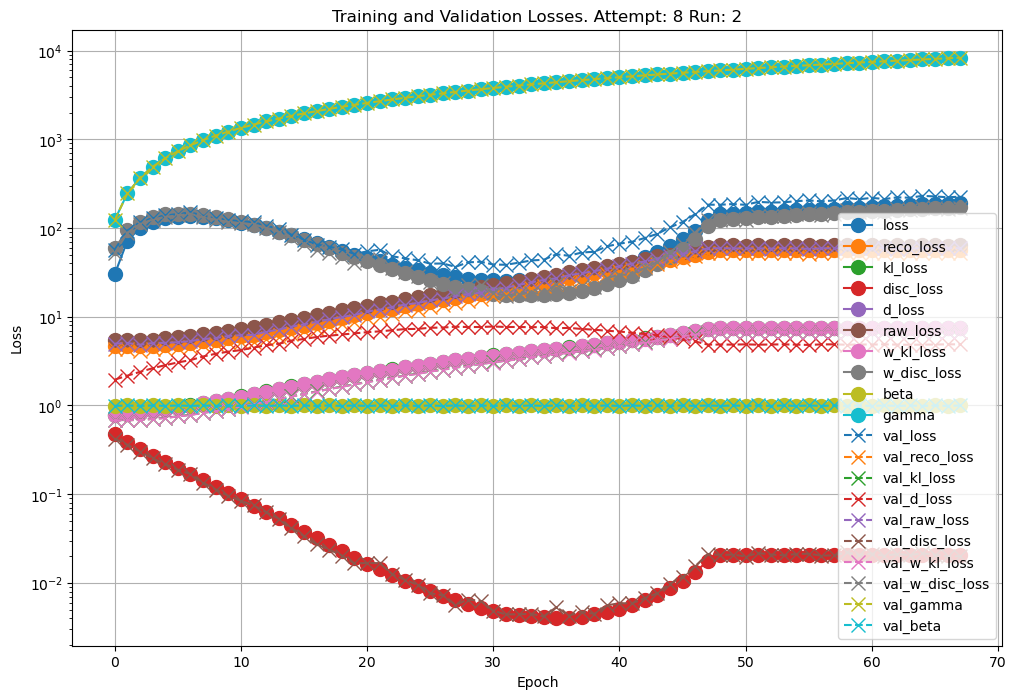

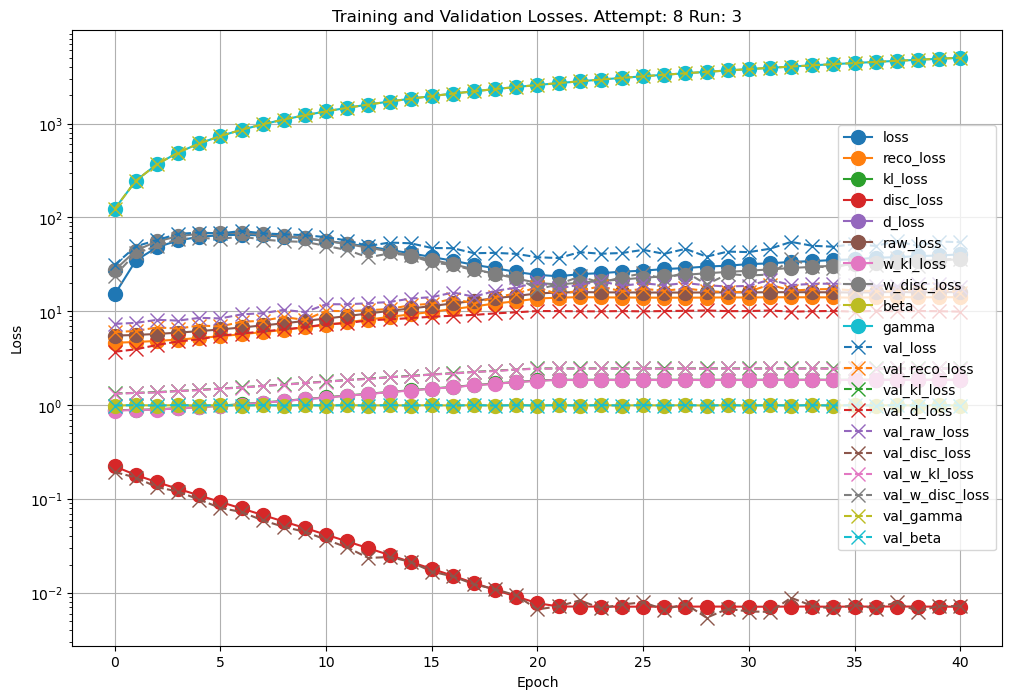

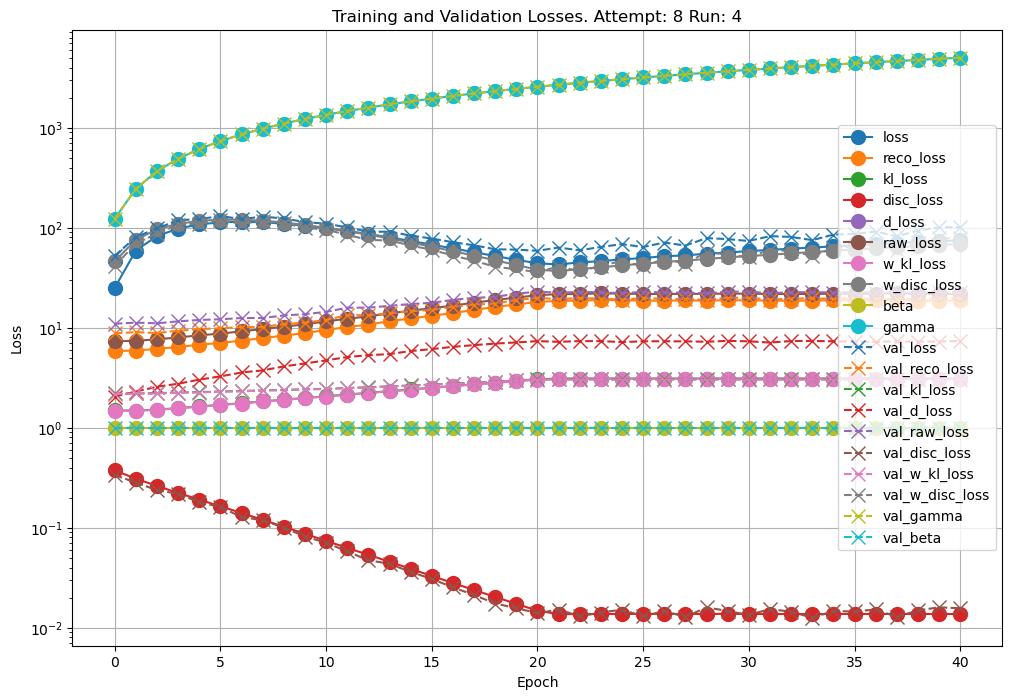

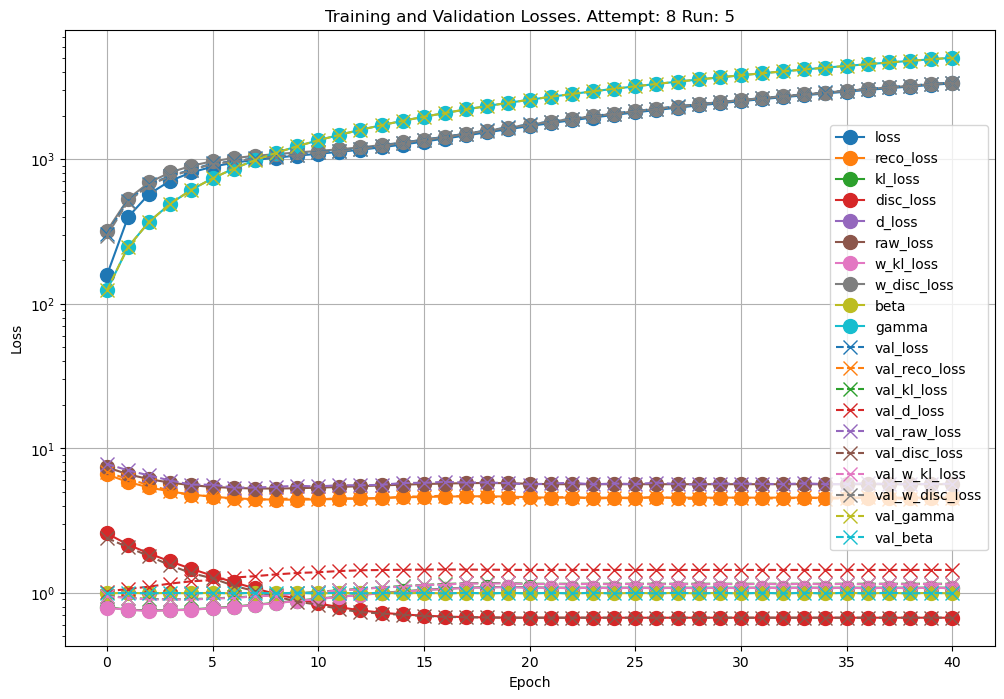

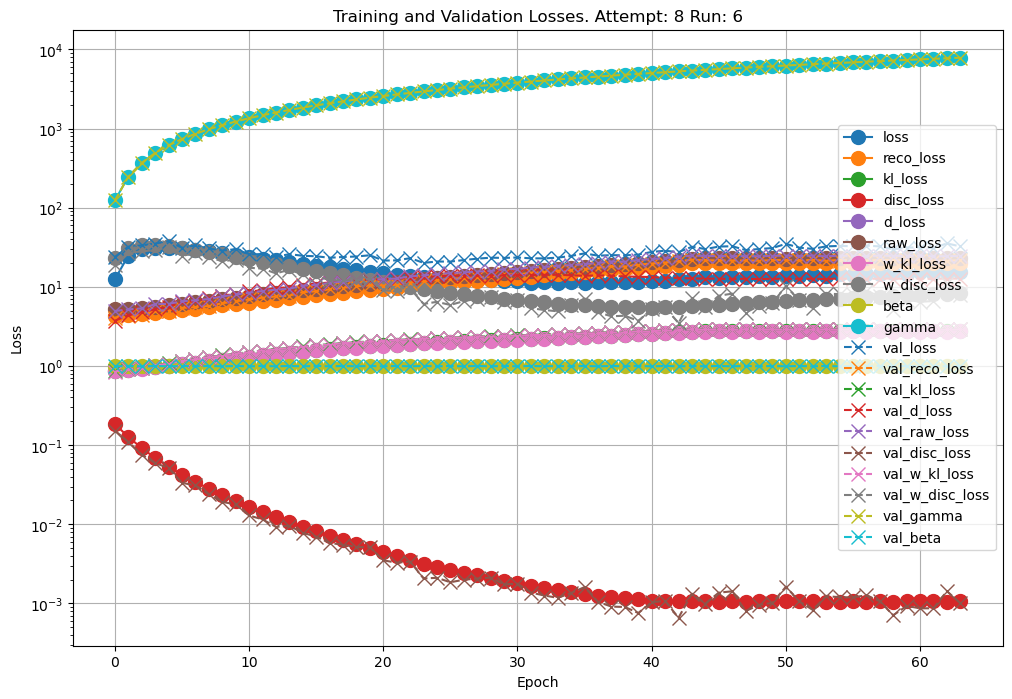

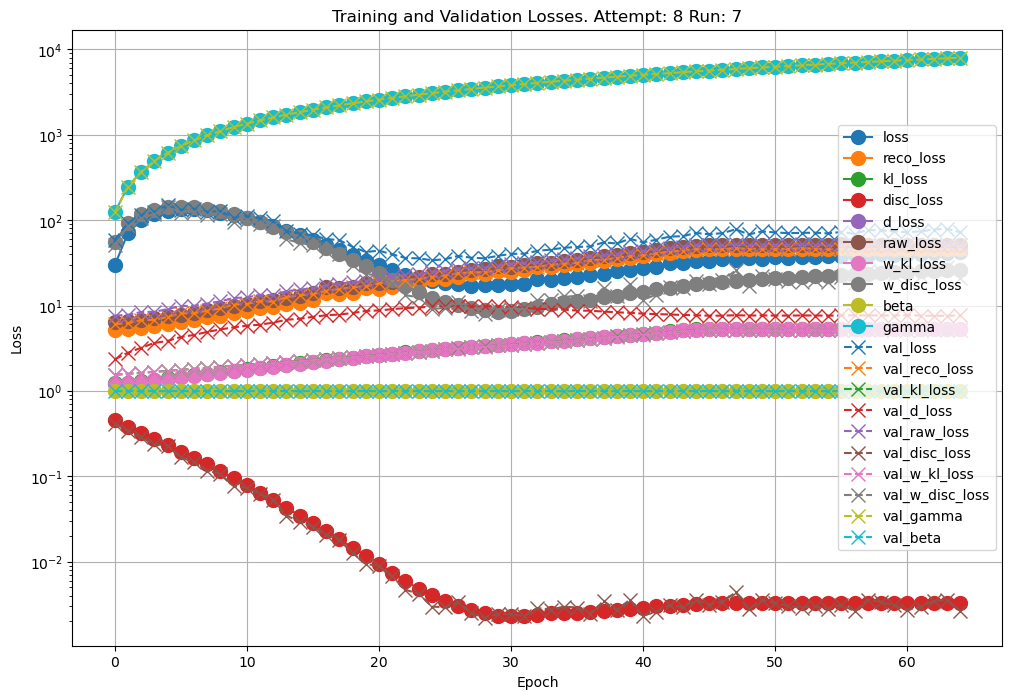

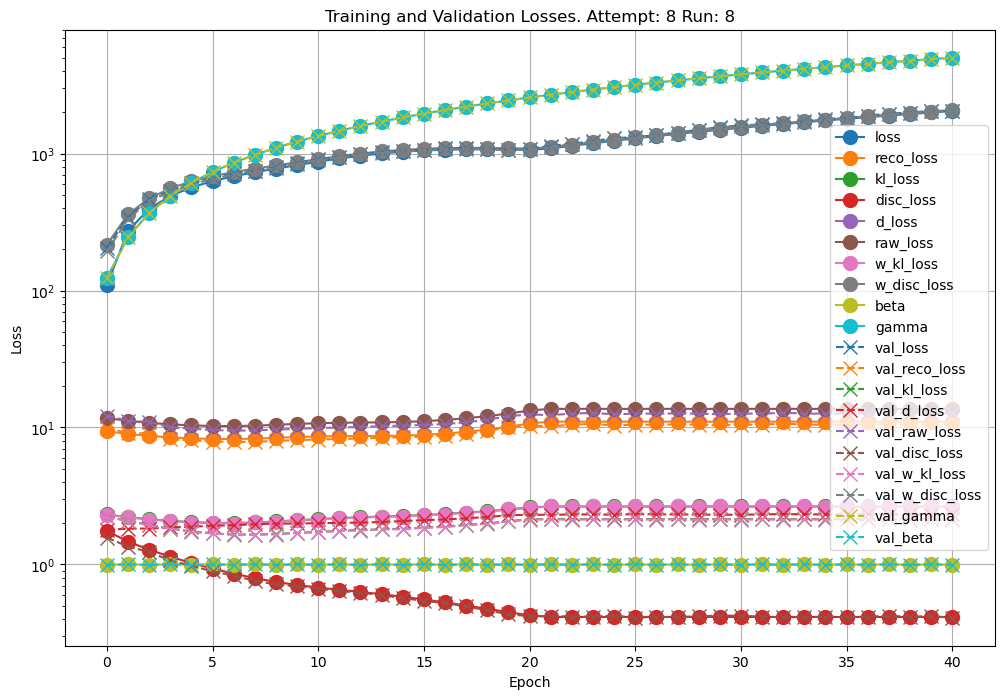

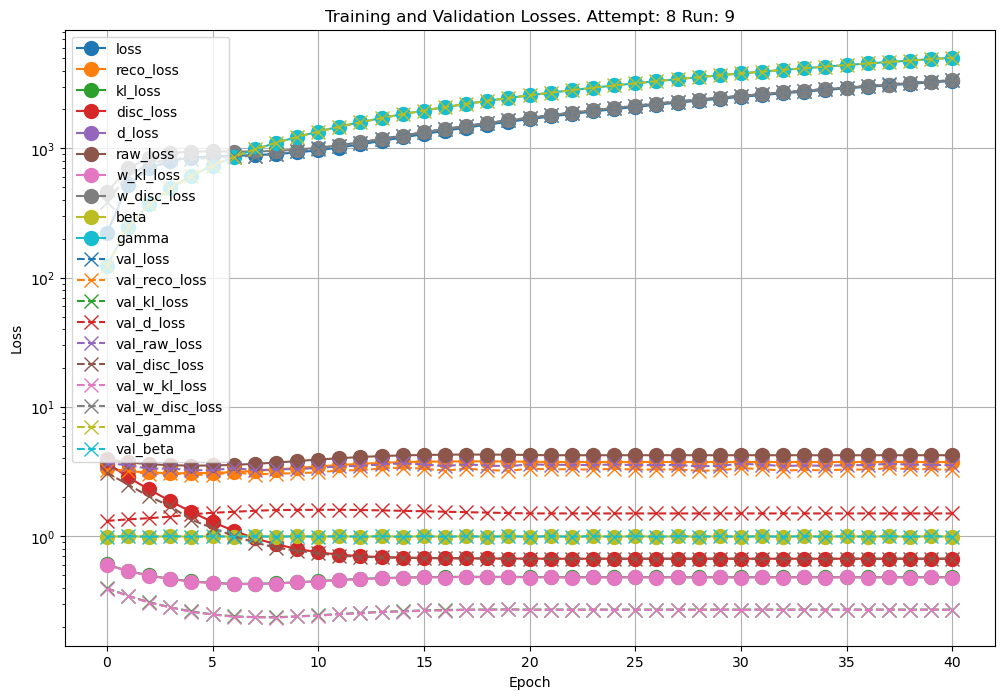

In [6]:
# Quick and dirty Loss plots while we're at it
for i in range(NUM_TRAIN):
    save_path = SAVE_PATH + f"n_{i}/"
    with open(save_path + 'training_history.pkl', 'rb') as f:
        history = pkl.load(f)

    
    # Plot training losses
    plt.figure(figsize=(12, 8))
    for key, val in history.items():
        if key == 'lr':
            continue
        plt.plot(val, label=key, 
                 linestyle = "dashed" if key[0:3] == 'val' else "solid",
                 marker= "x" if key[0:3] == 'val' else "o",
                 markersize=10) 


    # Customize the plot
    plt.title(f'Training and Validation Losses. Attempt: {ATTEMPT_NUM} Run: {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.semilogy()

    # Show the plot
    plt.show()